In [1]:
# Import library tf dan image data generator
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Download dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-07-25 15:49:32--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  5.88MB/s    in 74s     

2020-07-25 15:50:48 (4.15 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
# Ekstrasi dataset ke folder /tmp
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [11]:
# Memeriksa isi folder dataset
os.listdir('/tmp/rockpaperscissors')

['README_rpc-cv-images.txt', 'rps-cv-images', 'rock', 'scissors', 'paper']

In [6]:
# Membuat folder untuk training dan testing dataset
try:
    os.mkdir('/tmp/training')
    os.mkdir('/tmp/testing')
    os.mkdir('/tmp/training/rock')
    os.mkdir('/tmp/training/scissors')
    os.mkdir('/tmp/training/paper')
    os.mkdir('/tmp/testing/rock')
    os.mkdir('/tmp/testing/scissors')
    os.mkdir('/tmp/testing/paper')
    
except OSError:
    pass

In [7]:
# Memisahkan dan membagi data training dan data testing pada tiap-tiap label, serta membagi nya menjadi 60% data training dan 40% data testing
import random
import shutil
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " Jika kosong, Abaikan.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

ROCK_SOURCE_DIR = "/tmp/rockpaperscissors/rock/"
TRAINING_ROCK_DIR = "/tmp/training/rock/"
TESTING_ROCK_DIR = "/tmp/testing/rock/"

SCISSORS_SOURCE_DIR = "/tmp/rockpaperscissors/scissors/"
TRAINING_SCISSORS_DIR = "/tmp/training/scissors/"
TESTING_SCISSORS_DIR = "/tmp/testing/scissors/"

PAPER_SOURCE_DIR = "/tmp/rockpaperscissors/paper/"
TRAINING_PAPER_DIR = "/tmp/training/paper/"
TESTING_PAPER_DIR = "/tmp/testing/paper/"

split_size = .6
split_data(ROCK_SOURCE_DIR, TRAINING_ROCK_DIR, TESTING_ROCK_DIR, split_size)
split_data(SCISSORS_SOURCE_DIR, TRAINING_SCISSORS_DIR, TESTING_SCISSORS_DIR, split_size)
split_data(PAPER_SOURCE_DIR, TRAINING_PAPER_DIR, TESTING_PAPER_DIR, split_size)

In [8]:
# Memeriksa hasil split(pembagian)
print(len(os.listdir('/tmp/training/rock/')))
print(len(os.listdir('/tmp/training/scissors/')))
print(len(os.listdir('/tmp/training/paper/')))
print(len(os.listdir('/tmp/testing/rock/')))
print(len(os.listdir('/tmp/testing/scissors/')))
print(len(os.listdir('/tmp/testing/paper/')))

435
450
427
291
300
285


In [50]:
# Inisiasi datagen untuk training dan testing 
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

In [51]:
# Menyesuaikan data image generator
TRAINING_DIR = '/tmp/training'
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=50,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = '/tmp/testing'
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=50,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [52]:
# Inisiasi model
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')]
)

In [53]:
# Compile Model.
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [54]:
# Menggunakan fungsi callback
class panggilCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\n Proses Training dibatalkan jika sudah mencapai akurasi 95%")
            self.model.stop_training = True

callbacks = panggilCallback()

In [55]:
# Training Model
history = model.fit(train_generator,
                    steps_per_epoch=15,
                    epochs=30,
                    validation_data=validation_generator, 
                    validation_steps=3,
                    verbose=2,
                    callbacks=[callbacks])


Epoch 1/30
15/15 - 33s - loss: 3.3025 - accuracy: 0.3244 - val_loss: 1.0753 - val_accuracy: 0.3267
Epoch 2/30
15/15 - 34s - loss: 1.0917 - accuracy: 0.4467 - val_loss: 1.4305 - val_accuracy: 0.3400
Epoch 3/30
15/15 - 33s - loss: 1.1221 - accuracy: 0.4930 - val_loss: 0.8337 - val_accuracy: 0.8333
Epoch 4/30
15/15 - 33s - loss: 0.9892 - accuracy: 0.5140 - val_loss: 0.7881 - val_accuracy: 0.6000
Epoch 5/30
15/15 - 33s - loss: 0.8855 - accuracy: 0.5899 - val_loss: 0.6981 - val_accuracy: 0.7333
Epoch 6/30
15/15 - 33s - loss: 0.8875 - accuracy: 0.6124 - val_loss: 0.6768 - val_accuracy: 0.7133
Epoch 7/30
15/15 - 34s - loss: 0.7840 - accuracy: 0.6733 - val_loss: 1.0675 - val_accuracy: 0.5600
Epoch 8/30
15/15 - 33s - loss: 0.7516 - accuracy: 0.6994 - val_loss: 0.4532 - val_accuracy: 0.8267
Epoch 9/30
15/15 - 35s - loss: 0.7009 - accuracy: 0.7051 - val_loss: 0.5703 - val_accuracy: 0.6933
Epoch 10/30
15/15 - 33s - loss: 0.6642 - accuracy: 0.7233 - val_loss: 0.3348 - val_accuracy: 0.8800
Epoch 11/

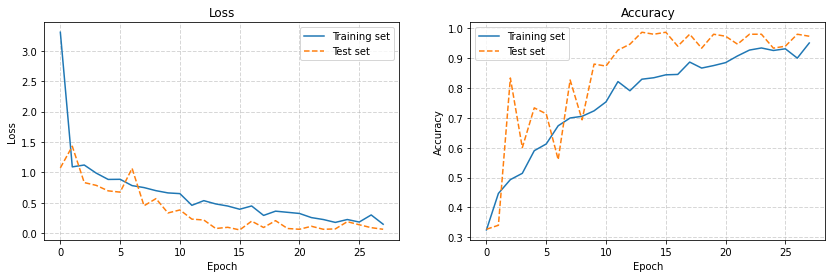

In [56]:
# Melihat hasil akurasi apakah overfitting atau underfitting
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)


plt.show()

Using TensorFlow backend.


Saving close-up-rock-paper-scissors-hands-isolated-white-background-151750538 - Copy.jpg to close-up-rock-paper-scissors-hands-isolated-white-background-151750538 - Copy.jpg
close-up-rock-paper-scissors-hands-isolated-white-background-151750538 - Copy.jpg
[[1. 0. 0.]]
Paper


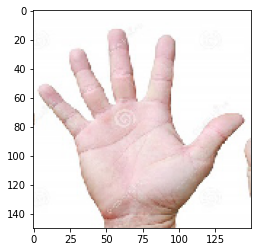

In [57]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=50)
  
  print(fn)
  print(classes)
 
  if classes[0][0] == 1:
    print('Paper')
  elif classes[0][1] == 1:
    print('Rock')
  elif classes[0][2] == 1:
    print('Scissors')
  else:
    print('Not Found')